In [1]:
import numpy as np
import pandas as pd

#读入.content文件
cora_content = pd.read_csv('./data/cora.content',sep='\t',header=None)
#查看数据集初始格式
print(cora_content.shape)
print(cora_content.head(3))


(2708, 1435)
      0     1     2     3     4     5     6     7     8     9     ...  1425  \
0    31336     0     0     0     0     0     0     0     0     0  ...     0   
1  1061127     0     0     0     0     0     0     0     0     0  ...     0   
2  1106406     0     0     0     0     0     0     0     0     0  ...     0   

   1426  1427  1428  1429  1430  1431  1432  1433                    1434  
0     0     1     0     0     0     0     0     0         Neural_Networks  
1     1     0     0     0     0     0     0     0           Rule_Learning  
2     0     0     0     0     0     0     0     0  Reinforcement_Learning  

[3 rows x 1435 columns]


In [2]:
#读取.cites文件
cora_cites = pd.read_csv('./data/cora.cites',sep='\t',header=None)
#查看数据集初始格式
print(cora_cites.shape)
print(cora_cites.head(3))

(5429, 2)
    0       1
0  35    1033
1  35  103482
2  35  103515


In [3]:
content_idx = list(cora_content.index) #将索引制作成列表
paper_id = list(cora_content.iloc[:,0]) #将content第一列取出
mp = dict(zip(paper_id,content_idx)) #映射成{论文id:索引编号}的字典形式
#查看某个论文id对应的索引编号
mp[31336]


0

In [4]:
#切片提取从第一列到倒数第二列（左闭右开）
feature = cora_content.iloc[:,1:-1]
#查看特征矩阵
feature.shape
feature.head(3)


,1,2,3,4,5,6,7,8,9,10,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
label = cora_content.iloc[:,-1] #提取最后一列
label = pd.get_dummies(label) #独热编码
#查看标签的独热表示
label.head(3)


,Case_Based,Genetic_Algorithms,Neural_Networks,Probabilistic_Methods,Reinforcement_Learning,Rule_Learning,Theory
0,False,False,True,False,False,False,False
1,False,False,False,False,False,True,False
2,False,False,False,False,True,False,False


In [6]:
mat_size = cora_content.shape[0] #第一维的大小2708就是邻接矩阵的规模
adj_mat = np.zeros((mat_size,mat_size)) #创建0矩阵
mat_size


2708

In [7]:
#创建邻接矩阵
for i,j in zip(cora_cites[0],cora_cites[1]): #枚举形式（u，v）
    x = mp[i]
    y = mp[j]
    adj_mat[x][y] = adj_mat[y][x] = 1


In [8]:
sum(sum(adj_mat))

10556.0

In [9]:
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# 读取数据
cora_content = pd.read_csv('./data/cora.content', sep='\t', header=None)
cora_cites = pd.read_csv('./data/cora.cites', sep='\t', header=None)

# 准备节点特征和标签
labels = pd.get_dummies(cora_content.iloc[:, -1]).values.argmax(axis=1)
features = cora_content.iloc[:, 1:-1].values
node_features = torch.tensor(features, dtype=torch.float)

# 准备边索引
paper_ids = cora_content.iloc[:, 0]
id_map = {j: i for i, j in enumerate(paper_ids)}
edges = cora_cites.applymap(lambda x: id_map[x]).values
edge_index = torch.tensor(edges.T, dtype=torch.long)

# 准备图数据
data = Data(x=node_features, edge_index=edge_index, y=torch.tensor(labels, dtype=torch.long))

# 划分数据集
indices = np.arange(data.num_nodes)
train_idx, test_idx = train_test_split(indices, test_size=0.1, random_state=0, stratify=labels)

# 创建训练集、验证集索引
train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=0, stratify=labels[train_idx])

data.train_idx = torch.tensor(train_idx, dtype=torch.long)
data.val_idx = torch.tensor(val_idx, dtype=torch.long)
data.test_idx = torch.tensor(test_idx, dtype=torch.long)

# 输出一些统计信息
print("Total nodes:", data.num_nodes)
print("Total edges:", data.num_edges)
print("Train nodes:", len(train_idx))
print("Validation nodes:", len(val_idx))
print("Test nodes:", len(test_idx))


Total nodes: 2708
Total edges: 5429
Train nodes: 2193
Validation nodes: 244
Test nodes: 271


In [10]:
from types import SimpleNamespace
import torch

config = SimpleNamespace(
    seed = 0,
    learning_rate = 0.001,
    weight_decay = 1e-4,  # 调整权重衰减，适合小型图数据集
    input_dim = 1433,  # Cora特征维度
    output_dim = 7,  # Cora标签类别数
    hidden_size = 128,
    num_epochs = 200,
    checkpoints_dir = './models/cora_gnn',
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

print("Using device:", config.device)


Using device: cuda


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import GATv2Conv

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    device = y_pred.device
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()
    y_test = y_test.to(device)
    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    return acc

class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, dim_feature, heads=8):
        super(GAT, self).__init__()
        self.norm1 = BatchNorm1d(dim_in)
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.3)
        self.norm2 = BatchNorm1d(dim_h * heads)
        self.gat2_class = GATv2Conv(dim_h * heads, dim_out, heads=heads, concat=False, dropout=0.6)
        self.gat2_feature = GATv2Conv(dim_h * heads, dim_feature, heads=heads, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        h = self.norm1(x)
        h = self.gat1(h, edge_index)
        h = self.norm2(h)
        h = F.leaky_relu(h)
        out_class = self.gat2_class(h, edge_index)
        out_feature = self.gat2_feature(h, edge_index)
        return out_class, out_feature

class FullyConnectedDecoder(torch.nn.Module):
    def __init__(self, dim_feature, dim_out=1433):  # 修改输出维度以匹配原始特征维度
        super(FullyConnectedDecoder, self).__init__()
        self.fc1 = torch.nn.Linear(dim_feature, dim_out)

    def forward(self, x):
        x = self.fc1(x)
        return x

class GATAutoencoder(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, dim_feature, heads=8):
        super(GATAutoencoder, self).__init__()
        self.encoder = GAT(dim_in, dim_h, dim_out, dim_feature, heads)
        self.decoder = FullyConnectedDecoder(dim_feature, dim_in)  # 输出维度与输入特征维度一致

    def forward(self, x, edge_index):
        out_class, out_feature = self.encoder(x, edge_index)
        reconstructed = self.decoder(out_feature)
        return out_class, reconstructed, out_feature


In [12]:
import torch
import os
import copy

# 更新训练函数
def train_evaluate(model, data, criterion_class, criterion_recon, optimizer, config):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(config.num_epochs + 1):
        model.train()
        optimizer.zero_grad()

        out_class, reconstructed, out_feature = model(data.x.to(config.device), data.edge_index.to(config.device))
        loss_class = criterion_class(out_class[data.train_idx], data.y[data.train_idx].to(config.device))
        loss_recon = criterion_recon(reconstructed[data.train_idx], data.x[data.train_idx].to(config.device))

        loss = loss_class + loss_recon
        loss.backward(retain_graph=True)
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
            val_loss = criterion_class(out_class[data.val_idx], data.y[data.val_idx].to(config.device))

        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val Loss: {val_loss:.4f}')
            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model with best validation loss")
                torch.save(model.state_dict(), os.path.join(config.checkpoints_dir, f'gat1_autoencoder_epoch_{epoch}.pth'))

    return model

def test(model, data, config):
    model.load_state_dict(torch.load(os.path.join(config.checkpoints_dir, f'gat1_autoencoder_epoch_{config.num_epochs}.pth')))
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 不计算梯度
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))  # 接收所有返回值
        preds = torch.softmax(out_class, dim=1).max(1)[1]  # 获取预测的类别索引
    return preds



In [13]:
import torch
from torch.optim import Adam
import torch.nn as nn

# 设定随机种子以确保实验的可重复性
torch.manual_seed(config.seed)

# 设置模型的隐藏层大小、特征头输出维度、注意力头的数量及训练周期数
config.hidden_size = 64  # 减小隐藏层大小
config.dim_feature = 1433  # 根据Cora数据集特征维度设置
config.heads = 8  # 设置注意力机制的头数
config.num_epochs = 50  # 设置训练周期数

# 创建自编码器模型实例
autoencoder_model = GATAutoencoder(config.input_dim, config.hidden_size, config.output_dim, config.dim_feature, config.heads).to(config.device)

# 创建优化器
optimizer = Adam(autoencoder_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)


criterion_class = nn.CrossEntropyLoss()

# 创建均方误差损失函数，用于重构任务
criterion_recon = nn.MSELoss()

# 训练模型，并在训练过程中进行评估
trained_model = train_evaluate(autoencoder_model, data, criterion_class, criterion_recon, optimizer, config)

# 在此输出是为了确认训练完成
print("Training completed")


Epoch   0 | Train Loss: 2.068 | Val Loss: 1.9210
Saving model with best validation loss
Epoch  10 | Train Loss: 0.731 | Val Loss: 1.5812
Saving model with best validation loss
Epoch  20 | Train Loss: 0.410 | Val Loss: 1.1271
Saving model with best validation loss
Epoch  30 | Train Loss: 0.281 | Val Loss: 0.6927
Saving model with best validation loss
Epoch  40 | Train Loss: 0.208 | Val Loss: 0.4408
Saving model with best validation loss
Epoch  50 | Train Loss: 0.151 | Val Loss: 0.3636
Saving model with best validation loss
Training completed


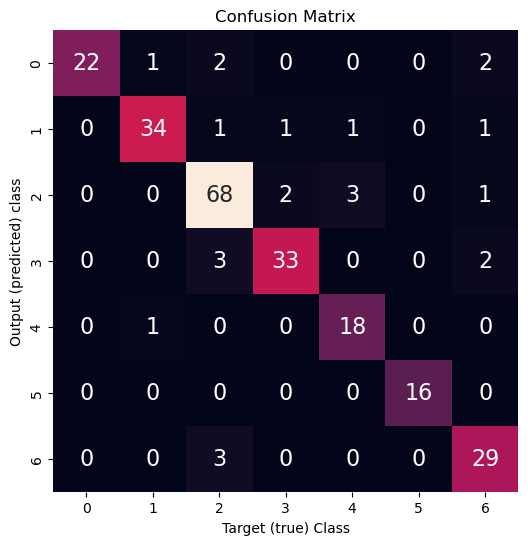

              precision    recall  f1-score   support

     Class 0       1.00      0.81      0.90        27
     Class 1       0.94      0.89      0.92        38
     Class 2       0.88      0.92      0.90        74
     Class 3       0.92      0.87      0.89        38
     Class 4       0.82      0.95      0.88        19
     Class 5       1.00      1.00      1.00        16
     Class 6       0.83      0.91      0.87        32

    accuracy                           0.90       244
   macro avg       0.91      0.91      0.91       244
weighted avg       0.91      0.90      0.90       244



In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 测试模型，并获取测试预测结果
y_test_preds = test(trained_model, data, config)

# 混淆矩阵
conf_mat = confusion_matrix(data.y[data.val_idx].detach().cpu().numpy(), y_test_preds[data.val_idx].cpu())
# 生成混淆矩阵。这个矩阵展示了模型在验证集上的预测结果与实际标签之间的关系。

plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt="d", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class')
plt.ylabel('Output (predicted) class')
plt.title('Confusion Matrix')
plt.show()
# 混淆矩阵的每个单元格显示实际类别与预测类别的匹配程度。

# 获取类别名称
class_labels = [f'Class {i}' for i in range(data.y.unique().max() + 1)]

# 分类报告
print(classification_report(data.y[data.val_idx].detach().cpu().numpy(), y_test_preds[data.val_idx].cpu(), target_names=class_labels))
# 这个报告提供了模型在各个类别上的精确度、召回率、F1分数等指标。


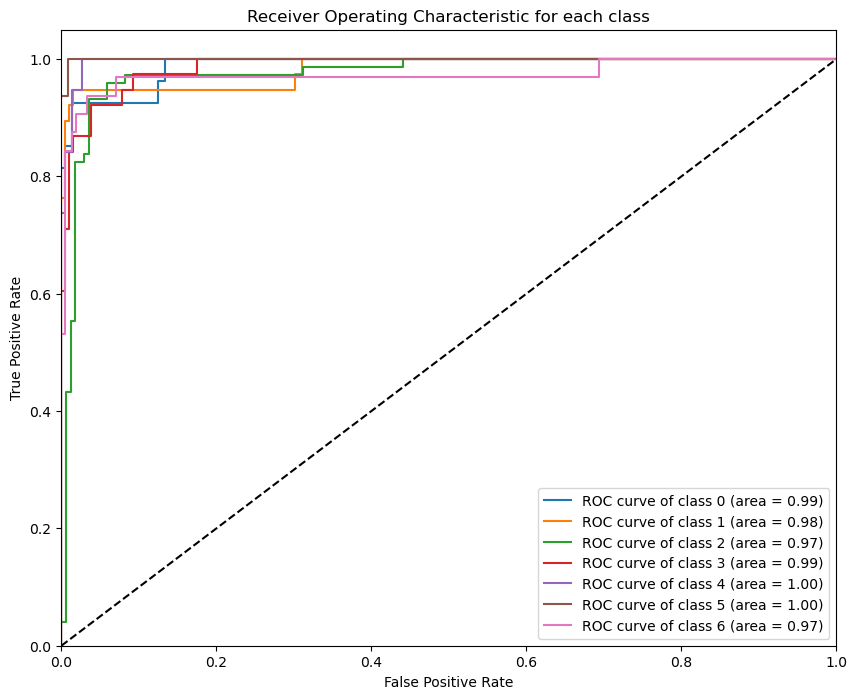

In [15]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def test(model, data, config):
    model_path = os.path.join(config.checkpoints_dir, f'gat1_autoencoder_epoch_{config.num_epochs}.pth')
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
        # 获取每个类别的概率分布
        preds_proba = F.softmax(out_class, dim=1)
    return preds_proba[data.val_idx]

# 测试模型并获取预测概率
y_test_proba = test(trained_model, data, config).cpu().numpy()
y_true = data.y[data.val_idx].detach().cpu().numpy()

# 二值化真实标签
num_classes = 7  # 标签从0到6，共有7个类别
y_true_binary = label_binarize(y_true, classes=range(num_classes))

# 计算每个类别的ROC AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


In [16]:
# 标签判别器，处理分类结果
class LabelDiscriminator(torch.nn.Module):
    def __init__(self, num_classes):
        super(LabelDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_classes, 64),  # 输入维度为类别数
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 特征判别器，处理特征向量
class FeatureDiscriminator(torch.nn.Module):
    def __init__(self, feature_dim):
        super(FeatureDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, features):
        return self.model(features)

# 示例初始化
label_discriminator = LabelDiscriminator(num_classes=7).to(config.device)
feature_discriminator = FeatureDiscriminator(feature_dim=1433).to(config.device)



In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader

def train_evaluate(model, label_discriminator, feature_discriminator, data, criterion_class, criterion_recon, optimizer, optimizer_D, optimizer_FD, config):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    criterion_D = torch.nn.BCELoss()
    criterion_FD = torch.nn.BCELoss()

    for epoch in range(config.num_epochs + 1):
        model.train()
        label_discriminator.train()
        feature_discriminator.train()

        optimizer.zero_grad()
        optimizer_D.zero_grad()
        optimizer_FD.zero_grad()

        out_class, reconstructed, out_feature = model(data.x.to(config.device), data.edge_index.to(config.device))
        predicted_labels = F.softmax(out_class, dim=1).detach()  # Ensure we detach predicted labels

        loss_class = criterion_class(out_class[data.train_idx], data.y[data.train_idx].to(config.device))
        loss_recon = criterion_recon(reconstructed[data.train_idx], data.x[data.train_idx].to(config.device))

        real_labels = F.one_hot(data.y[data.train_idx].to(config.device), num_classes=7).float()  # Convert to one-hot
        real_loss = criterion_D(label_discriminator(real_labels), torch.ones(real_labels.size(0), 1, device=config.device))
        fake_loss = criterion_D(label_discriminator(predicted_labels[data.train_idx]), torch.zeros(predicted_labels[data.train_idx].size(0), 1, device=config.device))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward(retain_graph=True)  # Ensure we keep the graph for the next backward pass

        real_feature_loss = criterion_FD(feature_discriminator(data.x[data.train_idx].detach().to(config.device)), torch.ones(data.train_idx.size(0), 1, device=config.device))
        fake_feature_loss = criterion_FD(feature_discriminator(out_feature[data.train_idx].detach()), torch.zeros(data.train_idx.size(0), 1, device=config.device))
        fd_loss = (real_feature_loss + fake_feature_loss) / 2
        fd_loss.backward(retain_graph=True)  # Ensure we keep the graph for the next backward pass

        g_loss = (0.3 * loss_class + 0.4 * d_loss + 0.3 * fd_loss)
        g_loss.backward()  # Final backward pass where we do not need to retain the graph
        optimizer.step()

        if epoch % 10 == 0 or epoch == config.num_epochs:
            val_loss = evaluate(model, label_discriminator, feature_discriminator, data, criterion_class, criterion_D, criterion_FD, config)
            print(f'Epoch {epoch:>3} | Train Loss: {g_loss.item():.3f} | D Loss: {d_loss.item():.3f} | FD Loss: {fd_loss.item():.3f} | Val Loss: {val_loss:.3f}')
            if val_loss < best_loss:
                print("Saving model with best validation loss")
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f'{config.checkpoints_dir}/best2_model_epoch_{epoch}.pth')

    model.load_state_dict(best_model_wts)
    return model


def evaluate(model, label_discriminator, feature_discriminator, data, criterion_class, criterion_D, criterion_FD, config):
    model.eval()
    label_discriminator.eval()
    feature_discriminator.eval()
    with torch.no_grad():
        out_class, _, out_feature = model(data.x.to(config.device), data.edge_index.to(config.device))
        val_loss = criterion_class(out_class[data.val_idx], data.y[data.val_idx].to(config.device)).item()
    return val_loss

def test(model, data, config):
    model_path = os.path.join(config.checkpoints_dir, f'best2_model_epoch_{config.num_epochs}.pth')
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
        preds = torch.argmax(F.softmax(out_class, dim=1), dim=1)  # Using softmax to handle multi-class output
    return preds

In [18]:
torch.autograd.set_detect_anomaly(True)

In [19]:
# 设置随机种子以保证结果的可复现性
torch.manual_seed(config.seed)

# 更新隐藏层大小和特征头输出维度以适应Cora数据集
config.hidden_size = 64  # 减小隐藏层大小
config.dim_feature = 1433  # 减小特征头输出维度
config.heads = 8         # 设置注意力头的数量
config.num_epochs = 100  # 设置训练的轮次

# 创建模型实例
autoencoder_model = GATAutoencoder(config.input_dim, config.hidden_size, config.output_dim, config.dim_feature, config.heads).to(config.device)
autoencoder_model.load_state_dict(torch.load(os.path.join(config.checkpoints_dir, f'gat1_autoencoder_epoch_50.pth')))
# 创建优化器和损失函数
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
criterion_class = torch.nn.CrossEntropyLoss()  # 使用交叉熵损失函数，适用于多分类问题
criterion_recon = torch.nn.MSELoss()  # 均方误差损失函数，用于重构任务

# 定义标签和特征判别器及其优化器
label_discriminator = LabelDiscriminator(num_classes=7).to(config.device)
feature_discriminator = FeatureDiscriminator(feature_dim=config.dim_feature).to(config.device)

optimizer_label_D = Adam(label_discriminator.parameters(), lr=0.001)
optimizer_feature_D = Adam(feature_discriminator.parameters(), lr=0.001)

# 开始训练和评估模型
trained_model = train_evaluate(autoencoder_model, label_discriminator, feature_discriminator, data, criterion_class, criterion_recon, optimizer, optimizer_label_D, optimizer_feature_D, config)

# 注意：确保已经更新了 `data` 变量来指向 Cora 数据集的实例


Epoch   0 | Train Loss: 0.522 | D Loss: 0.694 | FD Loss: 0.691 | Val Loss: 0.355
Saving model with best validation loss
Epoch  10 | Train Loss: 0.514 | D Loss: 0.695 | FD Loss: 0.691 | Val Loss: 0.349
Saving model with best validation loss
Epoch  20 | Train Loss: 0.508 | D Loss: 0.695 | FD Loss: 0.691 | Val Loss: 0.362
Epoch  30 | Train Loss: 0.502 | D Loss: 0.694 | FD Loss: 0.691 | Val Loss: 0.392
Epoch  40 | Train Loss: 0.498 | D Loss: 0.694 | FD Loss: 0.691 | Val Loss: 0.430
Epoch  50 | Train Loss: 0.494 | D Loss: 0.695 | FD Loss: 0.692 | Val Loss: 0.433
Epoch  60 | Train Loss: 0.496 | D Loss: 0.694 | FD Loss: 0.692 | Val Loss: 0.456
Epoch  70 | Train Loss: 0.494 | D Loss: 0.695 | FD Loss: 0.691 | Val Loss: 0.478
Epoch  80 | Train Loss: 0.493 | D Loss: 0.694 | FD Loss: 0.691 | Val Loss: 0.483
Epoch  90 | Train Loss: 0.494 | D Loss: 0.695 | FD Loss: 0.691 | Val Loss: 0.501
Epoch 100 | Train Loss: 0.493 | D Loss: 0.695 | FD Loss: 0.691 | Val Loss: 0.511


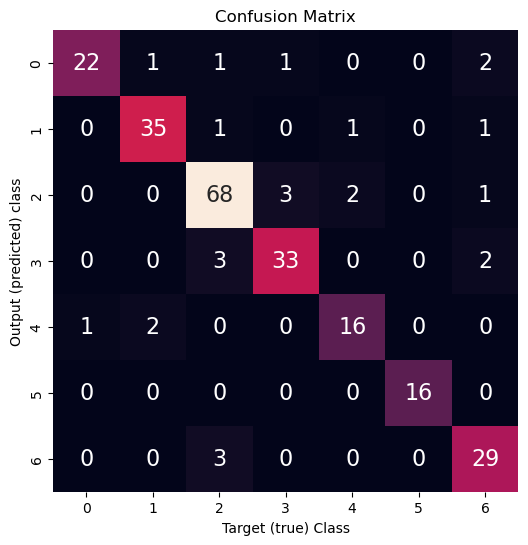

              precision    recall  f1-score   support

           0       0.96      0.81      0.88        27
           1       0.92      0.92      0.92        38
           2       0.89      0.92      0.91        74
           3       0.89      0.87      0.88        38
           4       0.84      0.84      0.84        19
           5       1.00      1.00      1.00        16
           6       0.83      0.91      0.87        32

    accuracy                           0.90       244
   macro avg       0.90      0.90      0.90       244
weighted avg       0.90      0.90      0.90       244



In [22]:
def test(model, data, config):
    model_path = os.path.join(config.checkpoints_dir, f'best2_model_epoch_10.pth')
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
        preds = torch.argmax(torch.softmax(out_class, dim=1), dim=1)  # Get the predicted classes
    return preds

y_test_preds = test(trained_model, data, config)

# 混淆矩阵
conf_mat = confusion_matrix(data.y[data.val_idx].detach().cpu().numpy(), y_test_preds[data.val_idx].cpu())
# 生成混淆矩阵。这个矩阵展示了模型在验证集上的预测结果与实际标签之间的关系。

plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt="d", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class')
plt.ylabel('Output (predicted) class')
plt.title('Confusion Matrix')
plt.show()
# 混淆矩阵的每个单元格显示实际类别与预测类别的匹配程度。

# 分类报告
print(classification_report(data.y[data.val_idx].detach().cpu().numpy(), y_test_preds[data.val_idx].cpu()))
# 这个报告提供了模型在各个类别上的精确度、召回率、F1分数等指标。由于有多个类别，不再需要指定具体的类别名称。


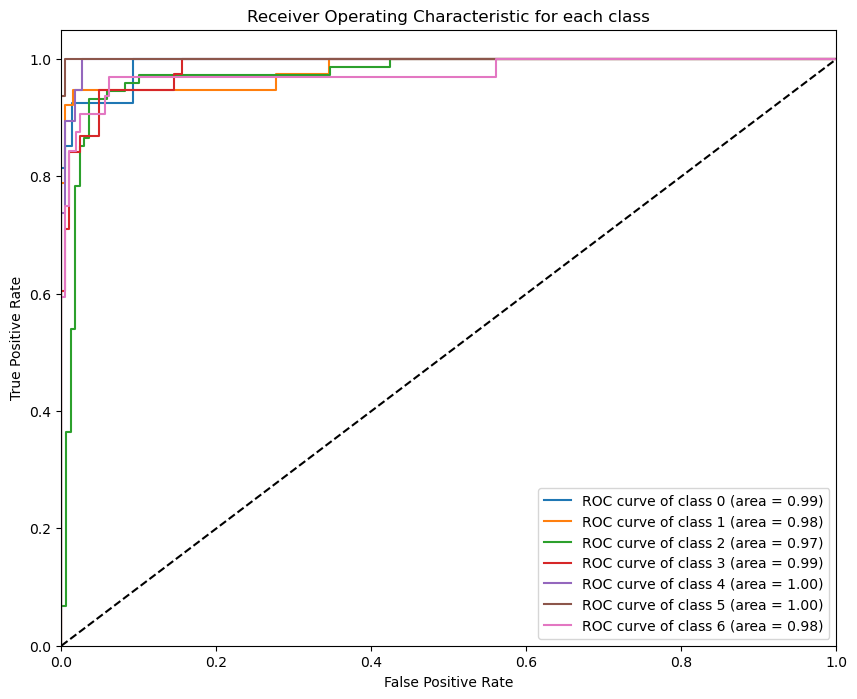

In [23]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def test(model, data, config):
    model_path = os.path.join(config.checkpoints_dir, f'best2_model_epoch_60.pth')
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        out_class, _, _ = model(data.x.to(config.device), data.edge_index.to(config.device))
        # 获取每个类别的概率分布
        preds_proba = F.softmax(out_class, dim=1)
    return preds_proba[data.val_idx]

# 测试模型并获取预测概率
y_test_proba = test(trained_model, data, config).cpu().numpy()
y_true = data.y[data.val_idx].detach().cpu().numpy()

# 二值化真实标签
num_classes = 7  # 标签从0到6，共有7个类别
y_true_binary = label_binarize(y_true, classes=range(num_classes))

# 计算每个类别的ROC AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

